In [1]:
!date

Wed Oct 25 14:44:14 EDT 2023


# Grab lake contours bigger than 5 degrees - no time tracking
## Make distance and direction field, lake by lake (that is, time by time)
#### from all available datafiles with a couple hundred hours in them
#### resulting filenames end in distance.nc

------------


In [2]:
from shapely import geometry
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import fiona             # a read-write library for shapefiles
import os         
#from descartes.patch import PolygonPatch

from shapely.geometry import Point
import pyproj
geodesic = pyproj.Geod(ellps='WGS84')

from glob import glob
import xarray as xr
#import dask.array as da

import pandas as pd
import geopandas as gp
from datetime import datetime

In [3]:
files = glob('/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/*distance.nc')

In [4]:
# Make directories for the outputs 

for ifile in range( len(files) ):  
    file = files[ifile] # replace with a loop to do all the MERRA2_MINIMAL data files
    print(file)
    
# folder to put results in: make it if it doesn't exist
    path = file[0:67]+'/TIMELEVELS/'
    os.makedirs(path, exist_ok=True)
    datestr = file[67:80]
    pathpath = file[0:67]+'/TIMELEVELS/'+datestr+'/'
    os.makedirs(pathpath, exist_ok=True)
    print(pathpath)

/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/2015_03_21_09_lat5p130N.M2_min2D_distance.nc
/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL//TIMELEVELS/2015_03_21_09/
/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/2017_05_06_18_lat1p979S.M2_min2D_distance.nc
/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL//TIMELEVELS/2017_05_06_18/
/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/2015_04_30_02_lat0p276N.M2_min2D_distance.nc
/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL//TIMELEVELS/2015_04_30_02/
/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/2014_05_11_18_lat2p131S.M2_min2D_distance.nc
/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL//TIMELEVELS/2014_05_11_18/
/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/2018_03_19_12_lat9p318S.M2_min2D_distance.nc
/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIM

In [5]:
file = files[0]
path = file[0:67]+"TIMELEVELS/"
os.makedirs(path, exist_ok=True)
path

'/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/TIMELEVELS/'

In [ ]:
# CRS warnings are annoying below, I might suppress all just for readability

import warnings
warnings.filterwarnings("ignore")

# A function to return a GeoDataFrame of polygons 

In [6]:
# loop over contour collections (and polygons in each collection)
# store in polylist  
def gdf_from_contours(lon,lat,tqv,conlevel):
    
    levels = [conlevel, 9e9] # needs a second level for some reason, infinity
    cs = plt.contourf(lon,lat,tqv,levels) 
# create lookup table for levels
    lvl_lookup = dict(zip(cs.collections, cs.levels))
    
    zvalues, polylist  = [], []
    i=0 # initialize a counter 
    
    for col in cs.collections:
        z=lvl_lookup[col] # the value of the contour isopleth
        for contour_path in col.get_paths():
#        print('contour path: ',i)

        # create the multipolygon for this value of the field
            for ncp,cp in enumerate(contour_path.to_polygons()):
#            print('   ncp: ', ncp)
                lons = np.array(cp)[:,0]
                lats = np.array(cp)[:,1]
                new_shape = geometry.Polygon([(i[0], i[1]) for i in zip(lons,lats)])            
                if ncp == 0:
                    poly = new_shape # first shape
                else:
                    poly = poly.difference(new_shape) # Remove the holes

            polylist.append(poly)
            zvalues.append(z)
            gdf = gp.GeoDataFrame(geometry=polylist)
            gdf['tqv_values']=zvalues
        
    return(gdf)

------------

# Open each dataset in xarray, and loop over all times in it

In [8]:
MINSIZE = 5 # square degrees, smallest area lake (closed contour at an instant) to process 

In [38]:
lake = gp.GeoDataFrame(single_row_df, geometry='geometry').set_crs(epsg = "4256", inplace = True)            
lake

,geometry,tqv_values,perimeter,area,centroidlat,centroidlon,centriod_is_inside,maxlon,minlon,maxlat,minlat,contournum
5,"POLYGON ((33.12686 5.20384, 33.75186 5.14526, ...",55.0,4.286774,0.97846,5.461308,33.676237,True,34.48817,32.669924,5.878804,5.036612,5


0 /Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/2015_03_21_09_lat5p130N.M2_min2D_distance.nc
time:  0
out of bounds or too small  0
out of bounds or too small  1


/var/folders/v9/8pr92c8s0m14426rc7jfm2c80000gn/T/ipykernel_66124/2266438907.py:41: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if( (inbounds.values[0] == True) & (lake.area.values[0] > MINSIZE) ):
/var/folders/v9/8pr92c8s0m14426rc7jfm2c80000gn/T/ipykernel_66124/2266438907.py:41: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if( (inbounds.values[0] == True) & (lake.area.values[0] > MINSIZE) ):
/var/folders/v9/8pr92c8s0m14426rc7jfm2c80000gn/T/ipykernel_66124/2266438907.py:41: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if( (inbounds.values[0] == True) & (lake.area.values[0] > MINS

ds = ds.assign(distance2=(['lat','lon'],dist))
ds = ds.assign(dir_to2=(['lat','lon'],dir_to))
out of bounds or too small  3
out of bounds or too small  4


/var/folders/v9/8pr92c8s0m14426rc7jfm2c80000gn/T/ipykernel_66124/2266438907.py:41: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if( (inbounds.values[0] == True) & (lake.area.values[0] > MINSIZE) ):
/var/folders/v9/8pr92c8s0m14426rc7jfm2c80000gn/T/ipykernel_66124/2266438907.py:41: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if( (inbounds.values[0] == True) & (lake.area.values[0] > MINSIZE) ):


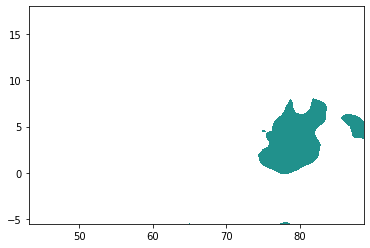

In [42]:
all_gdflakes = [] # collect them all in one big set of single closed contours ("lakes") 

for nfile,ifile in enumerate( range( 1)): #len(files) ) ):  
    file = files[ifile] # replace with a loop to do all the MERRA2_MINIMAL data files
    print(nfile, file)
    
# folder to put results in: make it if it doesn't exist
    path = file[0:67]+"/TIMELEVELS/"
    os.makedirs(path, exist_ok=True)
    datestr = file[67:80]
    pathpath = file[0:67]+"/TIMELEVELS/"+datestr+'/'
    os.makedirs(pathpath, exist_ok=True)

    bigds = xr.open_dataset(file)
    
    # Make an array of Points that are the gridpoints of MERRA2 in this file
    lat2d = bigds.lat.values[:,None]   + bigds.lon.values*0
    lon2d = bigds.lat.values[:,None]*0 + bigds.lon.values
    points = gp.GeoSeries( [Point(x, y) for x, y in zip(lon2d.ravel(),lat2d.ravel()) ] )\
            .set_crs(epsg = "4256", inplace = True)
     
# TIME LOOP OVER ALL TIMES: SLICE OFF ds DATASET - 2D ONLY
    for itime in range(1): #len(bigds.time)): 
        print('time: ',itime)
        ds = bigds.isel(time=itime).drop_vars(['distance','dir_from_centroid'])
        gdf = gdf_from_contours(ds.lon,ds.lat,ds.tqv, 55.)
        
# Iterate over rows in the GeoDataFrame
        for i, row in gdf.iterrows():
    # Create a DataFrame containing the current row
            single_row_df = gdf.iloc[[i]]
    
    # Convert the DataFrame back to a GeoDataFrame
            lake = gp.GeoDataFrame(single_row_df, geometry='geometry').set_crs(epsg = "4256", inplace = True)            
            
            # don't count it if the contour touches the edge of the dataset
            inbounds = \
                (lake.geometry.bounds.minx > ds.lon.min().values) & (lake.geometry.bounds.maxx < ds.lon.max().values) & \
                (lake.geometry.bounds.miny > ds.lat.min().values) & (lake.geometry.bounds.maxy < ds.lat.max().values)
            
            if( (inbounds.values[0] == True) & (lake.area.values[0] > MINSIZE) ): 
                lake['perimeter']=lake.geometry.length
                lake['area']=lake.geometry.area
                lake['centroidlat']=lake.geometry.centroid.y
                lake['centroidlon']=lake.geometry.centroid.x
                lake['centriod_is_inside']= lake.geometry.contains(lake.geometry.centroid)
                lake['maxlon']=lake.geometry.bounds.maxx
                lake['minlon']=lake.geometry.bounds.minx
                lake['maxlat']=lake.geometry.bounds.maxy
                lake['minlat']=lake.geometry.bounds.miny
                lake['contournum']= i
                ## gdf_1.geometry.apply(lambda g: gdf_2.distance(g))

            # Compute distance field from perimiter:
                dist = lake.geometry.apply(lambda g: points.distance(g)).values.reshape(len(ds.lat),len(ds.lon))
                # points.distance(lake.geometry.boundary).values.reshape(len(ds.lat),len(ds.lon))
                isin = points.within(lake.geometry).values.reshape(len(ds.lat),len(ds.lon))
                dist *= (-2)*(isin-0.5)  # make SIGNED distance from boundary, positive is exterior 

# Direction to centroid of WHOLE LAKE at this time
                centlon = lake.centroidlon
                centlat = lake.centroidlat 
# use j in explicit loop over gridpoints, since geodesic takes scalar only. Inelegant but works. 
                dir_to = []
                for j in range(len(lon2d.ravel())): 
                    fwd_az,back_az,d = geodesic.inv(lon2d.ravel()[j], lat2d.ravel()[j], [centlon], [centlat])
                    dir_to.append(fwd_az+180)
                
                dist_to = np.array(dist).reshape(len(ds.lat),len(ds.lon))
                dir_to = np.array(dir_to).reshape(len(ds.lat),len(ds.lon))
        
                command = "ds = ds.assign(distance"+str(i)+"=(['lat','lon'],dist))"
                print(command)
                exec(command)
                command = "ds = ds.assign(dir_to"+str(i)+"=(['lat','lon'],dir_to))"
                print(command)
                exec(command)
                lake['filename'] = datestr+'_time'+str(itime)+'_distdirs.nc'
                all_gdflakes.append(lake) # giant list of all lakes at all times in all files 
            else: 
                print('out of bounds or too small ',i)
                
        # Output all the distance and dir_to for this time level for this dataset     
        #ds.to_netcdf(pathpath+datestr+'_time'+str(itime)+'_distdirs.nc')
        #ds.close()
        #print('Writing netCDF, all_gdflakes is up to ', len(all_gdflakes))


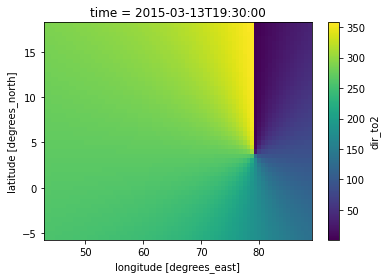

In [64]:
ds.dir_to2.plot()

In [52]:
                # Compute distance field from perimiter:
                dist = lake.geometry.apply(lambda g: points.distance(g)).values.reshape(len(ds.lat),len(ds.lon))
                # points.distance(lake.geometry.boundary).values.reshape(len(ds.lat),len(ds.lon))
                isin = points.within(lake.geometry).values.reshape(len(ds.lat),len(ds.lon))
                dist *= (-2)*(isin-0.5)  # make SIGNED distance from boundary, positive is exterior 

/var/folders/v9/8pr92c8s0m14426rc7jfm2c80000gn/T/ipykernel_66124/547892943.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist = lake.geometry.apply(lambda g: points.distance(g)).values.reshape(len(ds.lat),len(ds.lon))
/Users/brianmapes/opt/miniconda3/envs/geopy/lib/python3.10/site-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


0.0

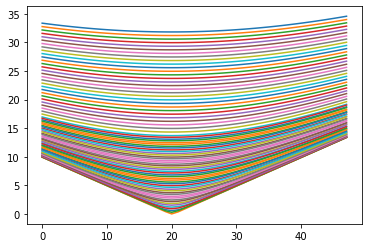

In [57]:
plt.plot(dist);
np.min(dist)

In [ ]:
        ds = bigds.isel(time=itime).drop_vars(['distance','dir_from_centroid'])
        ds

In [ ]:
# Iterate over rows in the GeoDataFrame
        for i, row in gdf.iterrows():
    # Create a DataFrame containing the current row
            single_row_df = gdf.iloc[[i]]
    
    # Convert the DataFrame back to a GeoDataFrame
            lake = gp.GeoDataFrame(single_row_df, geometry='geometry')            
            lake['perimeter']=lake.geometry.length
            lake['area']=lake.geometry.area
            lake['centroidlat']=lake.geometry.centroid.y
            lake['centroidlon']=lake.geometry.centroid.x
            lake['centriod_is_inside']= lake.geometry.contains(lake.geometry.centroid)
            lake['maxlon']=lake.geometry.bounds.maxx
            lake['minlon']=lake.geometry.bounds.minx
            lake['maxlat']=lake.geometry.bounds.maxy
            lake['minlat']=lake.geometry.bounds.miny
            lake['contournum']= i
            
            # don't count it if the contour touches the edge of the dataset
            inbounds = \
                (lake.minlon > ds.lon.min().values) & (lake.maxlon < ds.lon.max().values) & \
                (lake.minlat > ds.lat.min().values) & (lake.maxlat < ds.lat.max().values)
            if( (inbounds.values[0] == True) ): 

            # Compute distance field from perimiter:
                dist = points.distance(lake.geometry.boundary).values.reshape(len(ds.lat),len(ds.lon))
                isin = points.within(lake.geometry).values.reshape(len(ds.lat),len(ds.lon))
                dist *= (-2)*(isin-0.5)  # make SIGNED distance from boundary, positive is exterior 

# Direction to centroid of WHOLE LAKE at this time
                centlon = lake.centroidlon
                centlat = lake.centroidlat 
# use j in explicit loop over gridpoints, since geodesic takes scalar only. Inelegant but works. 
                dir_to = []
                for j in range(len(lon2d.ravel())): 
                    fwd_az,back_az,d = geodesic.inv(lon2d.ravel()[j], lat2d.ravel()[j], [centlon], [centlat])
                    dir_to.append(fwd_az+180)
                
                dist_to = np.array(dist).reshape(len(ds.lat),len(ds.lon))
                dir_to = np.array(dir_to).reshape(len(ds.lat),len(ds.lon))
        
                command = "ds = ds.assign(distance"+str(i)+"=(['lat','lon'],dist))"
                print(command)
                exec(command)
                command = "ds = ds.assign(dir_to"+str(i)+"=(['lat','lon'],dir_to))"
                print(command)
                exec(command)
                lake['filename'] = datestr+'_time'+str(itime)+'_distdirs.nc'
                all_gdflakes.append(lake) # giant list of all lakes at all times in all files 
            else: 
                print('out of bounds ',i)
                

In [ ]:
gdf.distance(points[0])

In [ ]:
gp.GeoDataFrame(single_row_df, geometry='geometry').geometry

In [ ]:
lake =gdf.iloc[[5]]

lake.plot()

In [ ]:
points.plot()

In [ ]:
# Check and set CRS if necessary
lake = lake.set_crs(gpoints.crs)
print(gpoints.crs)
print(lake.crs)

In [ ]:
print(points[0])  # Print the geometry of the 5th point

In [ ]:
lake.distance( points[5] )

In [ ]:
lake.distance( points[0] )

In [ ]:
lake.distance( lake.centroid )

In [ ]:
lake.distance(gpoints)

In [ ]:
dists = []
for n in range(len(points)): 
    dists.append( lake.distance( points[n] ) )

In [ ]:
plt.plot(dists)

In [ ]:
points[1:10].plot()

In [ ]:
lake.centroid

In [ ]:
print(gpoints.geom_type.head())  # Check the geometry types in gpoints
print(lake.geom_type)  # Check the geometry types in lake

In [ ]:
print(gpoints.geometry.is_valid.all())
print(lake.geometry.is_valid.all())

In [ ]:
gpoints.geometry = gpoints.geometry.buffer(0)
lake.geometry = lake.geometry.buffer(0)

In [ ]:
# Calculate distances for points inside the lake (distance to the exterior boundary)
distances_inside = gpoints.geometry.distance(lake.geometry)

# Create a new GeoDataFrame for points outside the lake
points_outside = gpoints[~gpoints.index.isin(distances_inside.index)]

# Calculate distances for points outside the lake (distance to the nearest point on the boundary)
distances_outside = points_outside.geometry.apply(lambda x: lake.geometry.distance(x))

# Combine distances from inside and outside points
all_distances = distances_inside.append(distances_outside)
all_distances

In [ ]:
gpoints.geometry = gpoints.geometry.buffer(0)
lake.geometry = lake.geometry.buffer(0)

In [ ]:
gdf

In [ ]:
gdf.iloc[[5]].plot()

In [ ]:
gdf.plot()

In [ ]:
gdf.explode()

In [ ]:
len(all_gdflakes)

In [ ]:
all_laks = pd.concat(all_gdflakes)

In [ ]:
all_laks.describe()

In [ ]:
# write geojson of lakes at this time into one file -- no need really 

with open('/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/AllLakeContours_2014-2018.geojson', 'w') as f:
    f.write(all_laks.to_json())

f.close()
 

In [ ]:
all_laks

In [ ]:
df = all_laks

-------------
# Composite rain by distance from contour for selected ones

In [ ]:
df = gp.read_file('/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/AllLakeContours_2014-2018.geojson')

In [ ]:
df.contournum.describe()

In [ ]:
# Big ones with short perimeters
bigrounds = df[(df.area > 300) & (df.perimeter < 200)]

In [ ]:
bigrounds.area.values

In [ ]:
bigrounds.geometry.values[0]

In [ ]:
bigrounds.contournum

In [ ]:
bigrounds.filename.values[0]

In [ ]:
fi = '/Users/brianmapes/Box/VaporLakes/data/LAKEBYLAKE/MERRA2_2D/MINIMAL/TIMELEVELS/'+\
    bigrounds.filename.values[0][0:13]+'/'+bigrounds.filename.values[0]
fi

### 

In [ ]:
ds = xr.open_dataset(fi)
ds

In [ ]:
ds.distance6.plot()

In [ ]:
# The big one is distance1, with the largest (negative) minimum
ds.distance14.min()

In [ ]:
ds.groupby_bins('distance1', bins=np.arange(-5.0, 10.0, 0.1)).mean()

In [ ]:
(ds.groupby_bins('distance1', bins=np.arange(-5.0, 10.0, 0.1)).mean().prectot*86400.).plot() # mm/d
(ds.groupby_bins('distance1', bins=np.arange(-5.0, 10.0, 0.1)).mean().tqv -40).plot() # inches
plt.title('PW-40 (mm) and MERRA2 prectot (mm/d) '+bigrounds.filename.values[0])

In [ ]:
# From Snigdha 

def process_one_time_slice(ds_t):
    # Check if all values in 'distance0' are NaN
    if np.all(np.isnan(ds_t['distance0'])):
        return None  # Return None if all values are NaN
    
    # Group the data by distance bins, ranging from -2 to 4 with intervals of 0.1
    ds_grouped_t = ds_t.groupby_bins('distance0', bins=np.arange(-2.0, 4.0, 0.1))
    
    # Initialize a list to hold individual binned DataArrays
    binned_data_list = []
    bin_names = []
    # Loop through each distance bin group
    for name, group in ds_grouped_t:
        # Use the bin name as a coordinate
        group['binned_distance'] = str(name)
        
        # Append the group to the list
        binned_data_list.append(group)
        bin_names.append(str(name))
    
    # Concatenate along a new dimension 'binned_distance'
    ds_reduced_t = xr.concat(binned_data_list, dim=xr.DataArray(bin_names, name='binned_distance', dims='binned_distance'))
  
    # Return the reduced dataset for this time slice
    return ds_reduced_t